Gui Nodes
=========

Gui Nodes are specialized nodes in Fiatlight, dedicated to functions which do not return values but instead displaying a user interface using ImGui widgets. Gui Nodes are called at every frame, ensuring that the GUI is always responsive and up-to-date.

Gui Nodes are particularly useful for:
* Displaying interactive visualizations (plots, etc)
* Creating dashboards
* Providing user controls (e.g., sliders, buttons) that alter global variables

> Notes:
> * Gui Nodes are not meant to return values
> * Your GUI function should be fast. If you need to perform heavy computations, consider using AnyDataWithGui, where the "on_change" callback can be used to cache heavy computations.

Example: Visualizing a Heart Curve with a GUI Node
--------------------------------------------------

In this example, we demonstrate how to create a GUI node that visualizes a heart curve. The size of the heart dynamically changes over time to simulate a heartbeat.

**Explanation**:
1. time_seconds: This function returns the current time in seconds and is set to always be re-evaluated at every frame.
2. heart_curve: Generates the x and y coordinates of a heart curve that changes size over time to simulate a heartbeat.
3. gui_curve: A GUI node that visualizes the heart curve using ImPlot. It updates the curve at every frame to reflect the beating heart.
4. gui_curve is a gui function. So, we wrap it in a GuiNode to display the heart curve with either
   `GuiNode(gui_curve)` or `graph.add_gui_node(gui_curve)`.

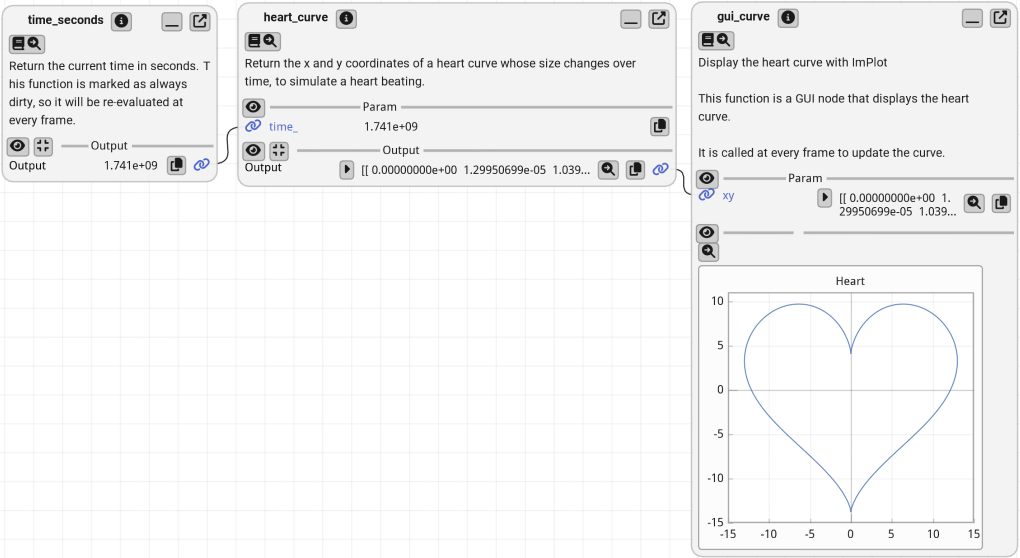

In [2]:
import fiatlight as fl
from imgui_bundle import hello_imgui, implot
import numpy as np
from numpy.typing import ArrayLike
import time

@fl.with_fiat_attributes(invoke_always_dirty=True)
def time_seconds() -> float:
    """Return the current time in seconds.
    This function is marked as always dirty, so it will be re-evaluated at every frame.
    """
    return time.time()

def heart_curve(time_: float) -> ArrayLike:
    """Return the x and y coordinates of a heart curve whose size changes over time,
    to simulate a heart beating.
    """
    vals = np.arange(0, np.pi * 2, 0.01)
    x0 = np.power(np.sin(vals), 3) * 16
    y0 = 13 * np.cos(vals) - 5 * np.cos(2 * vals) - 2 * np.cos(3 * vals) - np.cos(4 * vals)

    # Heart pulse rate and time tracking
    heart_pulse_rate = 80
    phase = time_ * heart_pulse_rate / (np.pi * 2)
    k = 0.8 + 0.1 * np.cos(phase)
    return np.array([x0 * k, y0 * k])

def gui_curve(xy: ArrayLike) -> None:
    """Display the heart curve with ImPlot

    This function is a GUI node that displays the heart curve.

    It is called at every frame to update the curve.
    """
    if implot.begin_plot("Heart", hello_imgui.em_to_vec2(21, 21)):
        implot.setup_axes_limits(-15, 15, -15, 11)
        implot.plot_line("", xy[0], xy[1])
        implot.end_plot()

# Run the graph
# Method 1: Using the run function, and wrapping the gui_curve function in a GuiNode
fl.run([time_seconds, heart_curve, fl.GuiNode(gui_curve)], app_name="HeartCurve")

# Method 2: Using a FunctionsGraph
# graph = fl.FunctionsGraph()
# graph.add_function(time_seconds)
# graph.add_function(heart_curve)
# graph.add_gui_node(gui_curve)  # Add the gui_curve function as a GuiNode
# graph.add_link(time_seconds, heart_curve)
# graph.add_link(heart_curve, gui_curve)
# fl.run(graph, app_name="HeartCurve")

Example: a GUI node with serializable state
-------------------------------------------

When adding a GuiNode, you can pass a serializable data class to store the options of the GUI function. This allows you to save the state of the GUI function and reload it when restarting the application.

In the example below, we demonstrate how to create a GUI node that multiplies an input value by a factor. The factor can be adjusted by the user and is stored in a serializable data class. The factor value is reloaded upon restarting the application.

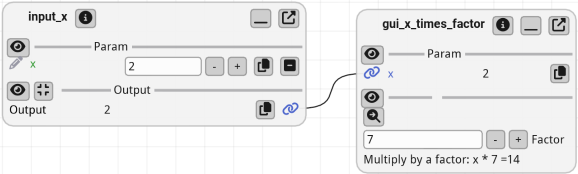

In [3]:
import fiatlight as fl
from imgui_bundle import imgui
from pydantic import BaseModel

def input_x(x: int) -> int:
    """a function that will be displayed in the function graph, in order to let the user input a value."""
    return x

class WhatToMultiply(BaseModel):
    """A serializable data class that will be used to store the options of the GUI function `gui_x_times_factor"""
    factor: int = 3

WHAT_TO_MULTIPLY = WhatToMultiply()

def gui_x_times_factor(x: int) -> None:
    """A GUI function that multiplies the input by a serializable factor.
    It will be added via graph.add_gui_node(gui_x_times_factor, gui_serializable_data=WHAT_TO_MULTIPLY).
    It uses a serializable data class to store its options, which will be reloaded upon restarting the application.
    """
    _, WHAT_TO_MULTIPLY.factor = imgui.input_int("Factor", WHAT_TO_MULTIPLY.factor)
    imgui.text(f"Multiply by a factor: x * {WHAT_TO_MULTIPLY.factor} ={x * WHAT_TO_MULTIPLY.factor}")

# Run the graph
fl.run([input_x, fl.GuiNode(gui_x_times_factor, gui_serializable_data=WHAT_TO_MULTIPLY)], app_name="GuiNode with serializable state")